# Machine Learning for Traffic Accident Analysis

## Introduction
In this notebook, I will build machine learning models to predict the **severity of traffic accidents** Based on other relative factors in the data using **scikit-learn (sklearn)**.  
The steps include:
- Preparing the dataset  
- Splitting data into training and testing sets
- Building baseline models (Logistic Regression, Decision Tree)  
- Training more advanced models (Random Forest, Gradient Boosting)  
- Evaluating results with classification metrics and confusion matrices  
- Saving the best model for future use  

With this we move from **exploring and visualizing** the dataset to **predicting accident severity**.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Loading cleaned dataset
df = pd.read_csv("../data/final_cleaned_accident_data.csv")

# Confirm load
print("Shape:", df.shape)
df.head()


Shape: (6985228, 40)


,Source,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,City,County,State,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,Source2,3,2016-02-08 05:46:00,39.865147,-84.058723,0.01,I-70 E,Dayton,Montgomery,OH,...,False,False,False,False,False,False,Night,Night,Night,Night
1,Source2,2,2016-02-08 06:07:59,39.928059,-82.831184,0.01,Brice Rd,Reynoldsburg,Franklin,OH,...,False,False,False,False,False,False,Night,Night,Night,Day
2,Source2,2,2016-02-08 06:49:27,39.063148,-84.032608,0.01,State Route 32,Williamsburg,Clermont,OH,...,False,False,False,False,True,False,Night,Night,Day,Day
3,Source2,3,2016-02-08 07:23:34,39.747753,-84.205582,0.01,I-75 S,Dayton,Montgomery,OH,...,False,False,False,False,False,False,Night,Day,Day,Day
4,Source2,2,2016-02-08 07:39:07,39.627781,-84.188354,0.01,Miamisburg Centerville Rd,Dayton,Montgomery,OH,...,False,False,False,False,True,False,Day,Day,Day,Day


## Data preperation

### Steps to take:
- Define the target variable (severity)
- Assign variable x for the stats to predict and y for the stats used for the prediction
- Select what features to use for prediction
- Extract time based features frpom Start_Time
- Encode catagorical variables as machine learning models only work with numbers
- scale continuous numerical features so the model doesnt become biased

In [5]:
# Use a sample of the dataset to avoid memory errors
df_sample = df.sample(500_000, random_state=42)  # 500k rows instead of 7M

y = df_sample["Severity"]
X = df_sample.drop(["Severity", "Start_Time", "Street", "City", "Zipcode"], axis=1)

# Extract time-based features
df_sample["Start_Time"] = pd.to_datetime(df_sample["Start_Time"])
X["Hour"] = df_sample["Start_Time"].dt.hour
X["DayOfWeek"] = df_sample["Start_Time"].dt.dayofweek
X["Month"] = df_sample["Start_Time"].dt.month

# Encode key categorical variables
categorical_cols = ["State", "Timezone", "Weather_Condition", 
                    "Wind_Direction", "Sunrise_Sunset"]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale continuous features
scaler = StandardScaler()
num_cols_to_scale = [
    "Distance(mi)", "Temperature(F)", "Wind_Chill(F)",
    "Humidity(%)", "Pressure(in)", "Visibility(mi)",
    "Wind_Speed(mph)", "Precipitation(in)"
]

X[num_cols_to_scale] = scaler.fit_transform(X[num_cols_to_scale])

# confirm dataset size
print("Final size of features:", X.shape)


Final size of features: (500000, 217)


## Results

The final feature set contains **500,000 rows** and **217 features**.  
This includes time-based features we created such as (`Hour`, `DayOfWeek`, `Month`), encoded categorical variables (e.g. `State`, `Weather_Condition`), and scaled numerical variables.  
This balanced dataset will be used to train and evaluate machine learning models in the next steps.


## Train/Test Split
- Split features (`X`) and target (`Y`) into random training and test sets
- Using Random splits as we are not trying to predict future accidents just how severe an accident could be based on other conditions
- typically 80/20 to ensure most of the data is trained but some left un-touched for testing

In [6]:
# 20% to test set
X_train, X_test, y_train, y_test = train_test_split(
    # using stratify so that the random split doesnt put more of one severity in the training set
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (400000, 217) (400000,)
Test set: (100000, 217) (100000,)


## Verify correct split

- Without using Stratified sampling, there can be inconsistencies in the sets (since )

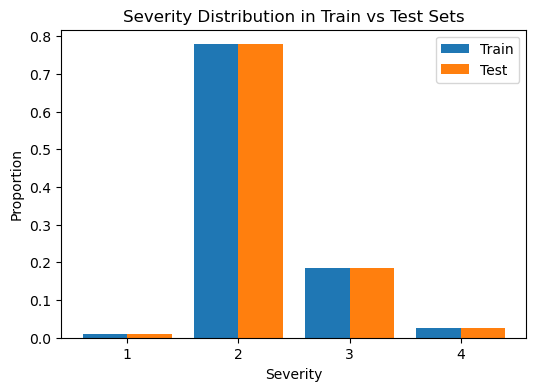

In [ ]:
train_counts = y_train.value_counts(normalize=True).sort_index()
test_counts = y_test.value_counts(normalize=True).sort_index()

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(train_counts.index - 0.2, train_counts, width=0.4, label="Train")
ax.bar(test_counts.index + 0.2, test_counts, width=0.4, label="Test")

ax.set_xticks([1,2,3,4])
ax.set_xlabel("Severity")
ax.set_ylabel("Proportion")
ax.set_title("Train vs Test Sets")
ax.legend()
plt.show()